In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from pprint import pprint

# torch.manual_seed(1337) ensures our training results can be repeated. 
# That’s important when debugging or running comparisons, randomness in
# weight initialization and batching can otherwise make runs inconsistent.
torch.manual_seed(3)
device = 'mps' if torch.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: mps


In [48]:
hidden_dim = 64 # Dimension of the hidden state
transformer_layers = 6 # Number of transformer layers
num_heads = 2 # Multi-head attention heads, lets model learn different representations of the input data
block_size = 32 # No of inputs blocks model can see at once
rms_norm_eps = 1e-5 # Epsilon value for RMS normalization
rope_theta = 10000.0

num_experts = 8 # Number of experts in the mixture of experts model per layer
select_experts_per_token = 2 # Top-K gating, for every token, router picks two experts
expert_output_dim = hidden_dim * 2 # Each expert MLP expands the token’s dimensionality to a wider hidden space before projecting it back down. 
shared_expert_output_dim = hidden_dim * 2 #  If we ever use shared FFNs, this would be their size. 

learning_rate = 5e-4
batch_size = 32 # We process 32 sequences at a time during training.
epochs = 1000
eval_interval = 200

assert hidden_dim % num_heads == 0, "hidden dim is not divisible by num heads"
dim_k = hidden_dim // num_heads
# Each attention head works on a chunk of the embedding, and this derived value defines how big that chunk is. For us: 128 / 4 = 32 per head.

In [49]:
input_data = ("Facebook was founded in a dorm room "
              "at Harvard by Mark Zuckerberg and " 
              "his roommates. What began as a small "
              "social experiment soon transformed "
              "into a global platform, connecting "
              "billions of people across the world. "
              "Over the years, it expanded beyond "
              "profiles and friend requests, "
              "introducing features like the News "
              "Feed, Messenger, and Marketplace.")
# This is our training data, which is the raw material our model will learn patterns from.
total_chars = len(input_data)

print(f"Training data has {total_chars} characters.")

Training data has 347 characters.


In [50]:
chars = sorted(list(set(input_data))) # all unique characters
# set() removes duplicates, sorted() sorts the characters
# This gives us a list of unique characters in the input data.
vocab_size = len(chars)

# We create a mapping from characters to integers and vice versa.
char_to_int = {i:idx for idx,i in enumerate(chars)}

# This is a dictionary that maps each character to a unique integer.
int_to_char = {idx:i for idx,i in enumerate(chars)}

pprint(char_to_int), pprint(int_to_char)

# Corresponding charaecters to integers mapping in the input data
# This is a list comprehension that iterates over each character in the input data
encoded_input_data = [char_to_int[ch] for ch in input_data]

# Convert the encoded input data to a PyTorch tensor
input_data_tensor = torch.tensor(encoded_input_data, dtype=torch.long, device=device)

len(input_data_tensor)

{' ': 0,
 ',': 1,
 '.': 2,
 'F': 3,
 'H': 4,
 'M': 5,
 'N': 6,
 'O': 7,
 'W': 8,
 'Z': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'k': 19,
 'l': 20,
 'm': 21,
 'n': 22,
 'o': 23,
 'p': 24,
 'q': 25,
 'r': 26,
 's': 27,
 't': 28,
 'u': 29,
 'v': 30,
 'w': 31,
 'x': 32,
 'y': 33}
{0: ' ',
 1: ',',
 2: '.',
 3: 'F',
 4: 'H',
 5: 'M',
 6: 'N',
 7: 'O',
 8: 'W',
 9: 'Z',
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'h',
 18: 'i',
 19: 'k',
 20: 'l',
 21: 'm',
 22: 'n',
 23: 'o',
 24: 'p',
 25: 'q',
 26: 'r',
 27: 's',
 28: 't',
 29: 'u',
 30: 'v',
 31: 'w',
 32: 'x',
 33: 'y'}


347

In [51]:
# Prepare training data (input-target pairs)
# Given a sequence of tokens, the model tries to predict the very next one.
# In every training example, we give it a chunk of tokens (x) and ask it to predict the next chunk (y),
# which is just x shifted one position forward.
input_x = []
output_y = []

for i in range(len(input_data_tensor) - block_size):
    
    x = input_data_tensor[i : i + block_size]
    y = input_data_tensor[i + 1 : i + block_size + 1]
    
    input_x.append(x)
    output_y.append(y)

# torch.stack these lists to create two large tensors, one for all inputs and one for all targets.
train_x = torch.stack(input_x)
train_y = torch.stack(output_y)

print(input_x[0]), print(output_y[0])

tensor([ 3, 10, 12, 14, 11, 23, 23, 19,  0, 31, 10, 27,  0, 15, 23, 29, 22, 13,
        14, 13,  0, 18, 22,  0, 10,  0, 13, 23, 26, 21,  0, 26],
       device='mps:0')
tensor([10, 12, 14, 11, 23, 23, 19,  0, 31, 10, 27,  0, 15, 23, 29, 22, 13, 14,
        13,  0, 18, 22,  0, 10,  0, 13, 23, 26, 21,  0, 26, 23],
       device='mps:0')


(None, None)

In [52]:
# maps each vocab_size unique tokens to a hidden_dim sized vector
# When we pass in a batch of token sequences (shape: B x T), 
# the output is a batch of embeddings (shape: B x T x d_model). 
character_embedding_map = nn.Embedding(vocab_size, hidden_dim).to(device)
character_embedding_map

Embedding(34, 64)

In [53]:
# Creates 1D positional encodings for each token in the input sequence.
# Generates numbers starting from 0 up to dim_k, with a step of 2.

# RoPE encodes position by rotating pairs of features inside query (Q) 
# and key (K) vectors. Instead of tacking on a separate position vector, 
# it twists the data inside Q and K using position-dependent angles.
rope_range = torch.arange(0, dim_k, 2, dtype=torch.float, device=device)
rope_freqs = 1.0 / (rope_theta ** (rope_range / dim_k))

In [54]:
# RMS layer - Normalizes based on the root mean square of the input.
# Gamma has learnaable parameter that allow the model to stretch or compress the normalized values.
# x / sqrt(E[x^2] + eps) * gamma + beta

# Two learnable paramter for each transformer layer, intialized to 1, and shape of (hidden_dim,)
# Act as gamma scaling factors in RMS normalization for each layer.
rms_before_attn = []
rms_after_attn = []

for i in range(transformer_layers):

    weight_before_attn = nn.Parameter(torch.ones(hidden_dim, device=device))
    rms_before_attn.append(weight_before_attn)

    weight_after_attn = nn.Parameter(torch.ones(hidden_dim, device=device))
    rms_after_attn.append(weight_after_attn)
    
# The final output of the transformer layer is also normalized.
rms_before_final_output = nn.Parameter(torch.ones(hidden_dim, device=device))

In [55]:
# Multi-head attention meaning each token will have multiple Q/K/V vectors.
# Each head will have its own set of Q/K/V matrices, and the output of all heads will be concatenated.

multi_head_layers = []
feed_forward_layers = []

# for each transformer layer.
for i in range(transformer_layers):

    # single layer to project from d_model to 3 * d_model
    qkv_layer = nn.Linear(hidden_dim, 3 * hidden_dim, bias=False).to(device)
    multi_head_layers.append(qkv_layer)

    feed_forw_layer = nn.Linear(hidden_dim, hidden_dim, bias=False).to(device)
    feed_forward_layers.append(feed_forw_layer)


In [56]:
router_layer = [] 
expert_feedforward_first_layer = []
expert_feedforward_second_layer = []  

shared_expert_layer = []
shared_expert_feedforward_first_layer = []
shared_expert_feedforward_second_layer = [] 


for i in range(transformer_layers):

    # Router layer that decides which experts to use for each token.
    # It takes the hidden state of the token and outputs a score for each expert.
    router_linear_layer = nn.Linear(hidden_dim, num_experts, bias=False).to(device)
    router_layer.append(router_linear_layer)

    # Each expert has its own feedforward network.
    # The first layer expands the token’s dimensionality to a wider hidden space.
    # The second layer projects it back down to the original hidden_dim.
    # Wraos the tensors as a learnable parameter, so they can be updated during training.
    expert_first_layer = nn.Parameter(torch.empty(num_experts, hidden_dim, 2 * expert_output_dim, device=device))
    nn.init.normal_(expert_first_layer, mean=0.0, std=0.05)
    expert_feedforward_first_layer.append(expert_first_layer)

    expert_second_layer = nn.Parameter(torch.empty(num_experts, expert_output_dim, hidden_dim, device=device))
    nn.init.normal_(expert_second_layer, mean=0.0, std=0.05)
    expert_feedforward_second_layer.append(expert_second_layer)

    # Shared feedforward layers for the experts.
    shared_gate = nn.Linear(hidden_dim, shared_expert_output_dim, bias=False).to(device)
    shared_feedforward_first_layer = nn.Linear(hidden_dim, shared_expert_output_dim, bias=False).to(device)
    shared_feedforward_second_layer = nn.Linear(shared_expert_output_dim, hidden_dim, bias=False).to(device)
    
    shared_expert_layer.append(shared_gate)
    shared_expert_feedforward_first_layer.append(shared_feedforward_first_layer)
    shared_expert_feedforward_second_layer.append(shared_feedforward_second_layer)

activation_fn = nn.SiLU()


In [57]:
# This is called a language modeling head, which is a linear layer that converts 
# the final hidden state of each token into a vector of size vocab_size.
language_modeling_head = nn.Linear(hidden_dim, vocab_size, bias=False).to(device)

# These scores are called logits. 
# They’re unnormalized, meaning they don’t sum to 1,
# that happens later via softmax during training or sampling.

In [58]:
# When generating text autoregressively, 
# one rule is meant to be followed, which is that the current token 
# shouldn't be able to look at future tokens.
# This is done by creating a lower triangular matrix of ones,
# which is then reshaped to match the dimensions of the attention scores.

# max sequence length (block_size)
# What is block_size?
# block_size is the maximum sequence length that the model can process at once.
# In language models, this is the maximum number of tokens (words, subwords, or characters) in an input sequence.
# For example, if block_size = 128, the model can handle up to 128 tokens per input.
lm_mask = torch.tril(torch.ones(block_size, block_size, device=device))
lm_mask = lm_mask.view(1, 1, block_size, block_size)
# Reshapes the mask to add batch and head dimensions,
# making it compatible with multi-head attention layers.


'''
Why is the causal mask shaped (1, 1, block_size, block_size)?

During attention computation, you deal with tensors shaped like:

(B, n_heads, T, T) → one attention matrix per head and per sequence.
By shaping the mask as (1, 1, block_size, block_size),

we make it broadcastable across:

All batches (B)
All attention heads (n_heads)
All sequence lengths (T)
'''
lm_mask

tensor([[[[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='mps:0')

In [59]:
#
trainable_parameters = list(character_embedding_map.parameters())

total_params = sum(p.numel() for p in trainable_parameters if p.requires_grad)

print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 2,176


In [60]:
trainable_parameters.extend(rms_before_attn)
trainable_parameters.extend(rms_after_attn)
trainable_parameters.append(rms_before_final_output)

total_params = sum(p.numel() for p in trainable_parameters if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 3,008


In [61]:
for i in range(transformer_layers):
    trainable_parameters.extend(list(multi_head_layers[i].parameters()))
    trainable_parameters.extend(list(feed_forward_layers[i].parameters()))

total_params = sum(p.numel() for p in trainable_parameters if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")


Total trainable parameters: 101,312


In [62]:
for i in range(transformer_layers):
    trainable_parameters.extend(list(router_layer[i].parameters()))

trainable_parameters.extend(expert_feedforward_first_layer)
trainable_parameters.extend(expert_feedforward_second_layer)

for i in range(transformer_layers):
    trainable_parameters.extend(list(shared_expert_layer[i].parameters()))
    trainable_parameters.extend(list(shared_expert_feedforward_first_layer[i].parameters()))
    trainable_parameters.extend(list(shared_expert_feedforward_second_layer[i].parameters()))

total_params = sum(p.numel() for p in trainable_parameters if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")


Total trainable parameters: 1,431,488


In [63]:
trainable_parameters.extend(list(language_modeling_head.parameters()))

total_params = sum(p.numel() for p in trainable_parameters if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 1,433,664


In [64]:
# AdamW, a variant of Adam with decoupled weight decay. 
# It’s the go-to optimizer for most Transformer models. 
# It is stable, fast-converging, and well-suited for handling sparse gradients
# and scale-sensitive layers like LayerNorm and embeddings.
optimizer = optim.AdamW(trainable_parameters, lr=learning_rate)

# Normally, when you define a model using nn.Module, 
# you just call model.parameters() and pass that to the optimizer.

In [65]:
# Since we’re training a language model that predicts the next token 
# at each position, the problem boils down to multi-class classification
# at every timestep.
criterion = nn.CrossEntropyLoss()

# Lastly, you don’t need to call softmax() separately.
#  The nn.CrossEntropyLoss() takes care of it internally.

For each token in the input sequence, the model outputs a logits vector, which is a raw score for every token in the vocabulary (e.g., 100+ possibilities for character-level, or 50,000+ for BPE models).

The loss function:

- Takes the predicted logits,
- Compares them against the true next-token ID (the ground truth),
- And computes how far off the model's guess was.

In [66]:
epoch_losses = []
total_samples = len(train_x)

for ep in range(epochs):
    
    # Each element is a random integer between 0 (inclusive) and total_samples (exclusive).
    # torch.randint(0, total_samples, (batch_size,)) generates a 1D tensor of length batch_size.
    batch_indices = torch.randint(0, total_samples, (batch_size,))
    
    input_tokens = train_x[batch_indices].to(device)
    target_tokens = train_y[batch_indices].to(device)

    bsz = input_tokens.shape[0]
    seq_len = input_tokens.shape[1]
    model_dim = hidden_dim

    embedded_tokens = character_embedding_map(input_tokens)

    # .unsqueeze(0) adds a new dimension at the front, changing the shape from (seq_len,) to (1, seq_len).
    # The extra dimension allows easy broadcasting when combining with batch
    pos_indices = torch.arange(seq_len, device=device).unsqueeze(0)

    # .unsqueeze(0) adds a batch dimension at the front: shape becomes (1, N).
    # .unsqueeze(-1) adds a singleton dimension at the end: shape becomes (1, N, 1).
    # .expand(bsz, -1, 1) repeats the tensor along the batch dimension (bsz times),
    #  keeping the other dimensions unchanged (-1 means "keep original size").
    inv_freq_broadcasted = rope_freqs.unsqueeze(0).unsqueeze(-1).expand(bsz, -1, 1)
    pos_ids_broadcasted = pos_indices.expand(bsz, -1).unsqueeze(1).float()

    with torch.autocast(device_type=device, enabled=False):
        angle_matrix = (inv_freq_broadcasted.float() @ pos_ids_broadcasted).transpose(1, 2)
        freqs_complex = torch.polar(torch.ones_like(angle_matrix), angle_matrix)

    layer_input = embedded_tokens

    for layer_id in range(transformer_layers):

        attn_residual = layer_input

        x_fp32 = layer_input.float()
        rms_norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
        normed_attn_input = (x_fp32 * rms_norm_factor).type_as(layer_input)
        normed_attn_input = normed_attn_input * rms_before_attn[layer_id]

        qkv_combined = multi_head_layers[layer_id](normed_attn_input)
        qkv_combined = qkv_combined.view(bsz, seq_len, num_heads, 3 * dim_k)
        queries, keys, values = qkv_combined.chunk(3, dim=-1)

        queries_reshaped = queries.float().reshape(bsz, seq_len, num_heads, -1, 2)
        keys_reshaped = keys.float().reshape(bsz, seq_len, num_heads, -1, 2)

        queries_complex = torch.view_as_complex(queries_reshaped)
        keys_complex = torch.view_as_complex(keys_reshaped)
        freq_broadcast = freqs_complex.unsqueeze(2)

        queries_rot = queries_complex * freq_broadcast
        keys_rot = keys_complex * freq_broadcast

        queries_real = torch.view_as_real(queries_rot)
        keys_real = torch.view_as_real(keys_rot)

        queries = queries_real.flatten(3).type_as(queries)
        keys = keys_real.flatten(3).type_as(keys)

        queries = queries.permute(0, 2, 1, 3)
        keys = keys.permute(0, 2, 1, 3)
        values = values.permute(0, 2, 1, 3)

        attention_scores = (queries @ keys.transpose(-2, -1)) * (dim_k ** -0.5)
        attention_scores = attention_scores.masked_fill(lm_mask[:, :, :seq_len, :seq_len] == 0, float('-inf'))

        attn_probs = F.softmax(attention_scores, dim=-1)
        attn_probs = torch.nan_to_num(attn_probs)

        attn_out = attn_probs @ values
        attn_out = attn_out.permute(0, 2, 1, 3).contiguous().view(bsz, seq_len, model_dim)

        attn_out = feed_forward_layers[layer_id](attn_out)

        layer_input = attn_residual + attn_out
        moe_residual = layer_input

        x_fp32 = layer_input.float()
        rms_norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
        normed_moe_input = (x_fp32 * rms_norm_factor).type_as(layer_input)
        normed_moe_input = normed_moe_input * rms_after_attn[layer_id]

        route_logits = router_layer[layer_id](normed_moe_input)

        expert_scores, expert_indices = torch.topk(route_logits, select_experts_per_token, dim=-1)
        expert_scores = torch.sigmoid(expert_scores)

        flattened_input = normed_moe_input.view(-1, model_dim)
        flattened_expert_ids = expert_indices.view(-1)
        flattened_scores = expert_scores.view(-1)

        token_positions = torch.arange(bsz * seq_len, device=device).repeat_interleave(select_experts_per_token)
        expert_routing = flattened_expert_ids

        expert_inputs = flattened_input[token_positions]

        expert_up_weights = expert_feedforward_first_layer[layer_id][expert_routing]
        expert_down_weights = expert_feedforward_second_layer[layer_id][expert_routing]

        intermediate = torch.bmm(expert_inputs.unsqueeze(1), expert_up_weights)
        gate_vals, up_vals = intermediate.chunk(2, dim=-1)

        expert_activated = activation_fn(gate_vals) * up_vals
        expert_raw_output = torch.bmm(expert_activated, expert_down_weights).squeeze(1)
        expert_scaled_output = expert_raw_output * flattened_scores.unsqueeze(-1)

        combined_outputs = torch.zeros_like(flattened_input)
        combined_outputs.scatter_add_(0, token_positions.unsqueeze(-1).expand(-1, model_dim), expert_scaled_output)

        shared_gate = shared_expert_layer[layer_id](normed_moe_input)
        shared_up = shared_expert_feedforward_first_layer[layer_id](normed_moe_input)
        shared_activated = activation_fn(shared_gate) * shared_up
        shared_down = shared_expert_feedforward_second_layer[layer_id](shared_activated)

        moe_out = combined_outputs.view(bsz, seq_len, model_dim)
        moe_combined = moe_out + shared_down

        layer_input = moe_residual + moe_combined

    x_fp32 = layer_input.float()
    rms_norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
    final_norm = (x_fp32 * rms_norm_factor).type_as(layer_input)
    final_norm = final_norm * rms_before_final_output

    vocab_logits = language_modeling_head(final_norm)

    B, T, V = vocab_logits.shape
    logits_flat = vocab_logits.view(B * T, V)
    targets_flat = target_tokens.view(B * T)
    loss = criterion(logits_flat, targets_flat)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_loss_val = loss.item()
    epoch_losses.append(current_loss_val)
    if ep % 2 == 0 or ep == epochs - 1:
        print(f"  Epoch {ep+1}/{epochs}, Loss: {current_loss_val:.4f}")


  Epoch 1/1000, Loss: 3.7216
  Epoch 3/1000, Loss: 3.4610
  Epoch 5/1000, Loss: 3.2192
  Epoch 7/1000, Loss: 3.0446
  Epoch 9/1000, Loss: 2.9065
  Epoch 11/1000, Loss: 2.7757
  Epoch 13/1000, Loss: 2.7103
  Epoch 15/1000, Loss: 2.6119
  Epoch 17/1000, Loss: 2.5643
  Epoch 19/1000, Loss: 2.4804
  Epoch 21/1000, Loss: 2.3923
  Epoch 23/1000, Loss: 2.3690
  Epoch 25/1000, Loss: 2.3463
  Epoch 27/1000, Loss: 2.3284
  Epoch 29/1000, Loss: 2.2412
  Epoch 31/1000, Loss: 2.1638
  Epoch 33/1000, Loss: 2.1516
  Epoch 35/1000, Loss: 2.1241
  Epoch 37/1000, Loss: 2.0961
  Epoch 39/1000, Loss: 2.1250
  Epoch 41/1000, Loss: 2.0754
  Epoch 43/1000, Loss: 2.0292
  Epoch 45/1000, Loss: 1.9590
  Epoch 47/1000, Loss: 1.9311
  Epoch 49/1000, Loss: 1.8731
  Epoch 51/1000, Loss: 1.7785
  Epoch 53/1000, Loss: 1.7195
  Epoch 55/1000, Loss: 1.6347
  Epoch 57/1000, Loss: 1.5867


KeyboardInterrupt: 

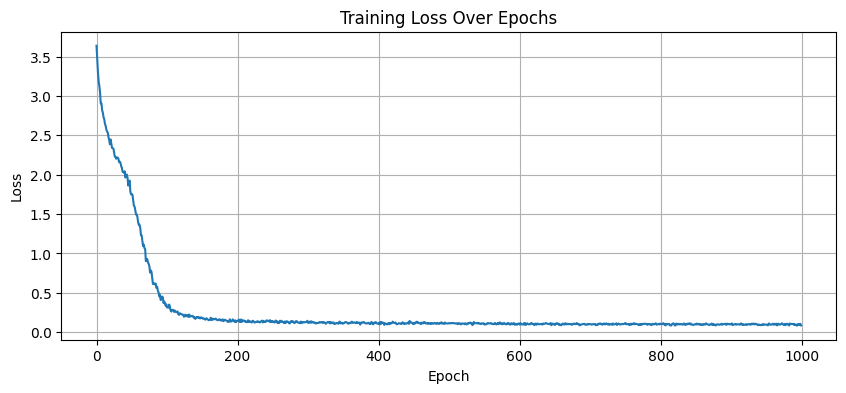

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(epoch_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [29]:
prompt_text = "Facebook " 

generation_limit = 100

prompt_token_ids = [char_to_int[ch] for ch in prompt_text if ch in char_to_int]
gen_sequence_buffer = torch.tensor([prompt_token_ids], dtype=torch.long, device=device)

character_embedding_map.eval()
for layer_idx in range(transformer_layers):
    multi_head_layers[layer_idx].eval()
    feed_forward_layers[layer_idx].eval()
    router_layer[layer_idx].eval()
    shared_expert_layer[layer_idx].eval()
    shared_expert_feedforward_first_layer[layer_idx].eval()
    shared_expert_feedforward_second_layer[layer_idx].eval()

language_modeling_head.eval()


Linear(in_features=64, out_features=34, bias=False)

In [30]:
with torch.no_grad():
    for _ in range(generation_limit):
        
        input_context = gen_sequence_buffer[:, -block_size:] 
        batch_size_gen, seq_len_gen = input_context.shape
        hidden_size_gen = hidden_dim

        embedded_input = character_embedding_map(input_context) 

        position_indices = torch.arange(seq_len_gen, device=device).unsqueeze(0)
        inv_freq_broadcast = rope_freqs.unsqueeze(0).unsqueeze(-1).expand(batch_size_gen, -1, 1)
        pos_ids_broadcast = position_indices.expand(batch_size_gen, -1).unsqueeze(1).float()
        
        with torch.autocast(device_type=device, enabled=False):
            pos_angles = (inv_freq_broadcast.float() @ pos_ids_broadcast).transpose(1, 2)
            rope_rotations = torch.polar(torch.ones_like(pos_angles), pos_angles)

        layer_input = embedded_input

        for layer_idx in range(transformer_layers):
            attn_skip = layer_input

            x_fp32 = layer_input.float()
            norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
            normed_input = (x_fp32 * norm_factor).type_as(layer_input)
            normed_input = normed_input * rms_before_attn[layer_idx]

            qkv_proj = multi_head_layers[layer_idx](normed_input)
            qkv_proj = qkv_proj.view(batch_size_gen, seq_len_gen, num_heads, 3 * dim_k)
            query, key, value = qkv_proj.chunk(3, dim=-1)

            query_cmplx = torch.view_as_complex(query.float().reshape(batch_size_gen, seq_len_gen, num_heads, -1, 2))
            key_cmplx = torch.view_as_complex(key.float().reshape(batch_size_gen, seq_len_gen, num_heads, -1, 2))
            rope_cis_broadcast = rope_rotations.unsqueeze(2)
            query_rot = query_cmplx * rope_cis_broadcast
            key_rot = key_cmplx * rope_cis_broadcast
            query = torch.view_as_real(query_rot).flatten(3).type_as(query)
            key = torch.view_as_real(key_rot).flatten(3).type_as(key)

            query = query.permute(0, 2, 1, 3)
            key = key.permute(0, 2, 1, 3)
            value = value.permute(0, 2, 1, 3)
            attn_scores = (query @ key.transpose(-2, -1)) * (dim_k ** -0.5)
            attn_scores = attn_scores.masked_fill(lm_mask[:, :, :seq_len_gen, :seq_len_gen] == 0, float('-inf'))
            attn_probs = F.softmax(attn_scores, dim=-1)
            attn_probs = torch.nan_to_num(attn_probs)
            attn_out = attn_probs @ value
            attn_out = attn_out.permute(0, 2, 1, 3).contiguous().view(batch_size_gen, seq_len_gen, hidden_size_gen)
            attn_out = feed_forward_layers[layer_idx](attn_out)

            layer_input = attn_skip + attn_out

            moe_skip = layer_input

            x_fp32 = layer_input.float()
            norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
            normed_input = (x_fp32 * norm_factor).type_as(layer_input)
            normed_input = normed_input * rms_after_attn[layer_idx]

            route_logits = router_layer[layer_idx](normed_input)
            topk_weights, topk_indices = torch.topk(route_logits, select_experts_per_token, dim=-1)
            topk_weights = torch.sigmoid(topk_weights)

            flattened_input = normed_input.view(-1, hidden_size_gen)
            flattened_expert_ids = topk_indices.view(-1)
            flattened_weights = topk_weights.view(-1)
            token_positions = torch.arange(batch_size_gen * seq_len_gen, device=device).repeat_interleave(select_experts_per_token)

            expert_inputs = flattened_input[token_positions]
            gate_up_weights = expert_feedforward_first_layer[layer_idx][flattened_expert_ids]
            down_weights = expert_feedforward_second_layer[layer_idx][flattened_expert_ids]

            up_states = torch.bmm(expert_inputs.unsqueeze(1), gate_up_weights)
            gate_vals, up_vals = up_states.chunk(2, dim=-1)
            activated = activation_fn(gate_vals) * up_vals
            expert_out_flat = torch.bmm(activated, down_weights).squeeze(1)
            scaled_expert_out = expert_out_flat * flattened_weights.unsqueeze(-1)

            combined_expert_out = torch.zeros_like(flattened_input)
            combined_expert_out.scatter_add_(
                0, token_positions.unsqueeze(-1).expand(-1, hidden_size_gen), scaled_expert_out
            )

            shared_gate = shared_expert_layer[layer_idx](normed_input)
            shared_up = shared_expert_feedforward_first_layer[layer_idx](normed_input)
            shared_activated = activation_fn(shared_gate) * shared_up
            shared_out = shared_expert_feedforward_second_layer[layer_idx](shared_activated)

            moe_combined = combined_expert_out.view(batch_size_gen, seq_len_gen, hidden_size_gen)
            final_moe_out = moe_combined + shared_out

            layer_input = moe_skip + final_moe_out

        x_fp32 = layer_input.float()
        norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
        final_norm = (x_fp32 * norm_factor).type_as(layer_input)
        final_norm = final_norm * rms_before_final_output

        vocab_logits = language_modeling_head(final_norm)
        logits_last_step = vocab_logits[:, -1, :] 

        token_probs = F.softmax(logits_last_step, dim=-1)
        sampled_token = torch.multinomial(token_probs, num_samples=1)

        gen_sequence_buffer = torch.cat((gen_sequence_buffer, sampled_token), dim=1)

In [31]:
gen_sequence_buffer

tensor([[ 3, 10, 12, 14, 11, 23, 23, 19,  0, 31, 10, 27,  0, 15, 23, 29, 22, 13,
         14, 13,  0, 18, 22,  0, 10,  0, 13, 23, 26, 21,  0, 26, 23, 23, 21,  0,
         10, 28,  0,  4, 10, 26, 30, 10, 26, 13,  0, 11, 33,  0,  5, 10, 26, 19,
          0,  9, 29, 12, 19, 14, 26, 11, 14, 26, 16,  0, 10, 22, 13,  0, 17, 18,
         27,  0, 26, 23, 23, 21, 21, 10, 28, 14, 27,  2,  0,  8, 17, 10, 28,  0,
         11, 14, 16, 10, 22,  0, 10, 27,  0, 10,  0, 27, 21, 10, 20, 20,  0, 27,
         23]])

In [32]:
final_generated_ids = gen_sequence_buffer[0].tolist()

decoded_text = ''.join([int_to_char.get(id_val, '[UNK]') for id_val in final_generated_ids])

print(decoded_text)

Facebook was founded in a dorm room at Harvard by Mark Zuckerberg and his roommates. What began as a small so


In [33]:
prompt_text = "Dorm rooms are " 

generation_limit = 100

prompt_token_ids = [char_to_int[ch] for ch in prompt_text if ch in char_to_int]
gen_sequence_buffer = torch.tensor([prompt_token_ids], dtype=torch.long, device=device)

character_embedding_map.eval()
for layer_idx in range(transformer_layers):
    multi_head_layers[layer_idx].eval()
    feed_forward_layers[layer_idx].eval()
    router_layer[layer_idx].eval()
    shared_expert_layer[layer_idx].eval()
    shared_expert_feedforward_first_layer[layer_idx].eval()
    shared_expert_feedforward_second_layer[layer_idx].eval()

language_modeling_head.eval()


Linear(in_features=64, out_features=34, bias=False)

In [34]:
with torch.no_grad():
    for _ in range(generation_limit):
        
        input_context = gen_sequence_buffer[:, -block_size:] 
        batch_size_gen, seq_len_gen = input_context.shape
        hidden_size_gen = hidden_dim

        embedded_input = character_embedding_map(input_context) 

        position_indices = torch.arange(seq_len_gen, device=device).unsqueeze(0)
        inv_freq_broadcast = rope_freqs.unsqueeze(0).unsqueeze(-1).expand(batch_size_gen, -1, 1)
        pos_ids_broadcast = position_indices.expand(batch_size_gen, -1).unsqueeze(1).float()
        
        with torch.autocast(device_type=device, enabled=False):
            pos_angles = (inv_freq_broadcast.float() @ pos_ids_broadcast).transpose(1, 2)
            rope_rotations = torch.polar(torch.ones_like(pos_angles), pos_angles)

        layer_input = embedded_input

        for layer_idx in range(transformer_layers):
            attn_skip = layer_input

            x_fp32 = layer_input.float()
            norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
            normed_input = (x_fp32 * norm_factor).type_as(layer_input)
            normed_input = normed_input * rms_before_attn[layer_idx]

            qkv_proj = multi_head_layers[layer_idx](normed_input)
            qkv_proj = qkv_proj.view(batch_size_gen, seq_len_gen, num_heads, 3 * dim_k)
            query, key, value = qkv_proj.chunk(3, dim=-1)

            query_cmplx = torch.view_as_complex(query.float().reshape(batch_size_gen, seq_len_gen, num_heads, -1, 2))
            key_cmplx = torch.view_as_complex(key.float().reshape(batch_size_gen, seq_len_gen, num_heads, -1, 2))
            rope_cis_broadcast = rope_rotations.unsqueeze(2)
            query_rot = query_cmplx * rope_cis_broadcast
            key_rot = key_cmplx * rope_cis_broadcast
            query = torch.view_as_real(query_rot).flatten(3).type_as(query)
            key = torch.view_as_real(key_rot).flatten(3).type_as(key)

            query = query.permute(0, 2, 1, 3)
            key = key.permute(0, 2, 1, 3)
            value = value.permute(0, 2, 1, 3)
            attn_scores = (query @ key.transpose(-2, -1)) * (dim_k ** -0.5)
            attn_scores = attn_scores.masked_fill(lm_mask[:, :, :seq_len_gen, :seq_len_gen] == 0, float('-inf'))
            attn_probs = F.softmax(attn_scores, dim=-1)
            attn_probs = torch.nan_to_num(attn_probs)
            attn_out = attn_probs @ value
            attn_out = attn_out.permute(0, 2, 1, 3).contiguous().view(batch_size_gen, seq_len_gen, hidden_size_gen)
            attn_out = feed_forward_layers[layer_idx](attn_out)

            layer_input = attn_skip + attn_out

            moe_skip = layer_input

            x_fp32 = layer_input.float()
            norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
            normed_input = (x_fp32 * norm_factor).type_as(layer_input)
            normed_input = normed_input * rms_after_attn[layer_idx]

            route_logits = router_layer[layer_idx](normed_input)
            topk_weights, topk_indices = torch.topk(route_logits, select_experts_per_token, dim=-1)
            topk_weights = torch.sigmoid(topk_weights)

            flattened_input = normed_input.view(-1, hidden_size_gen)
            flattened_expert_ids = topk_indices.view(-1)
            flattened_weights = topk_weights.view(-1)
            token_positions = torch.arange(batch_size_gen * seq_len_gen, device=device).repeat_interleave(select_experts_per_token)

            expert_inputs = flattened_input[token_positions]
            gate_up_weights = expert_feedforward_first_layer[layer_idx][flattened_expert_ids]
            down_weights = expert_feedforward_second_layer[layer_idx][flattened_expert_ids]

            up_states = torch.bmm(expert_inputs.unsqueeze(1), gate_up_weights)
            gate_vals, up_vals = up_states.chunk(2, dim=-1)
            activated = activation_fn(gate_vals) * up_vals
            expert_out_flat = torch.bmm(activated, down_weights).squeeze(1)
            scaled_expert_out = expert_out_flat * flattened_weights.unsqueeze(-1)

            combined_expert_out = torch.zeros_like(flattened_input)
            combined_expert_out.scatter_add_(
                0, token_positions.unsqueeze(-1).expand(-1, hidden_size_gen), scaled_expert_out
            )

            shared_gate = shared_expert_layer[layer_idx](normed_input)
            shared_up = shared_expert_feedforward_first_layer[layer_idx](normed_input)
            shared_activated = activation_fn(shared_gate) * shared_up
            shared_out = shared_expert_feedforward_second_layer[layer_idx](shared_activated)

            moe_combined = combined_expert_out.view(batch_size_gen, seq_len_gen, hidden_size_gen)
            final_moe_out = moe_combined + shared_out

            layer_input = moe_skip + final_moe_out

        x_fp32 = layer_input.float()
        norm_factor = torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
        final_norm = (x_fp32 * norm_factor).type_as(layer_input)
        final_norm = final_norm * rms_before_final_output

        vocab_logits = language_modeling_head(final_norm)
        logits_last_step = vocab_logits[:, -1, :] 

        token_probs = F.softmax(logits_last_step, dim=-1)
        sampled_token = torch.multinomial(token_probs, num_samples=1)

        gen_sequence_buffer = torch.cat((gen_sequence_buffer, sampled_token), dim=1)

print("...Generation loop finished.")


...Generation loop finished.


In [35]:
final_generated_ids = gen_sequence_buffer[0].tolist()

decoded_text = ''.join([int_to_char.get(id_val, '[UNK]') for id_val in final_generated_ids])

print(decoded_text)

orm rooms are t Wh began and frkerommmaterimates. beyond plat Overoon yerkermat and bey Mas aroHarvard his rkerber
